In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data
import warnings

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'


In [2]:
# read in
cal = pd.read_parquet(f'{folder_path}/data/005_data_cal.pq')
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
# covs = read_features(f'{folder_path}/benchmark_selected.covs_ocd.txt')
print(f'{len(covs)} covariates')

# initialize some parameter
n_jobs=90
cv = GroupKFold(n_splits=5) 
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

cal[tgt] = np.log1p(cal[prop])


# generate random numbers for organizing spatial cv
rng = np.random.default_rng(seed=43)
a = rng.integers(0,100, size=5)
print(a)


67 covariates
[50 65 40  4 57]


# Compute the model performance vs. tree number

[Oshiro et al. (2012)](https://link.springer.com/chapter/10.1007/978-3-642-31537-4_13) recommended a tree number range of 64 to 128. Here, we used a larger range to better suit the specific requirements of our case.

In [5]:
rsl = []
for ii in a:
    ttprint(f'cross val predict {prop}, in {space} space, random state {ii}')
    for n_trees in np.arange(16,240,8):
        ttprint('tree number: ', n_trees)
        model = RandomForestRegressor(random_state=ii, n_jobs=80, n_estimators=n_trees)
        y_cv = cross_val_predict(model, cal[covs], cal[tgt], cv=cv, groups=cal['tile_id'])#, n_jobs=60
        
        if space == 'log1p':
            # performance metrics
            rsl.append({
                'property': prop,
                'random state': ii,
                'tree number':n_trees,
                'MAE_cv_ori': mean_absolute_error(cal[prop],np.expm1(y_cv)),
                'MedAE_cv_ori': median_absolute_error(cal[prop],np.expm1(y_cv)),
                'MAPE_cv_ori': mean_absolute_percentage_error(cal[prop],np.expm1(y_cv)),
                'bias_cv_ori': np.mean(np.expm1(y_cv) - cal[prop]),
                'CCC_cv_ori': weighted_ccc(cal[prop],np.expm1(y_cv)),
                'R2_cv_ori': r2_score(cal[prop],np.expm1(y_cv)),
                'CCC_cv_log': weighted_ccc(cal[tgt],y_cv),
                'R2_cv_log': r2_score(cal[tgt],y_cv),
            })
            
        else:
            rsl.append({
                'property': prop,
                'random state': ii,
                'tree number':n_trees,
                'MAE_cv_ori': mean_absolute_error(cal[prop],y_cv),
                'MAPE_cv_ori': mean_absolute_percentage_error(cal[prop],y_cv),
                'MedAE_cv_ori': median_absolute_error(cal[prop],y_cv),
                'CCC_cv_ori': weighted_ccc(cal[prop],y_cv),
                'R2_cv_ori': r2_score(cal[prop],y_cv),
                'bias_cv_ori': np.mean(y_cv-cal[prop]),
                # 'MAE_cv_log': mean_absolute_error(np.log1p(cal[tgt]),np.log1p(y_cv)),
                # 'MAPE_cv_log': mean_absolute_percentage_error(np.log1p(cal[tgt]),np.log1p(y_cv)),
                # 'CCC_cv_log': calc_ccc(np.log1p(cal[tgt]),np.log1p(y_cv)),
                # 'R2_cv_log': r2_score(np.log1p(cal[tgt]),np.log1p(y_cv)),
                # 'bias_cv_log': np.mean(np.log1p(y_cv) - np.log1p(cal[tgt])),
            })
        
rsl = pd.DataFrame(rsl) 

[14:03:55] cross val predict ocd, in log1p space, random state 50
[14:03:55] tree number:  16
[14:03:58] tree number:  24
[14:04:01] tree number:  32
[14:04:05] tree number:  40
[14:04:09] tree number:  48
[14:04:12] tree number:  56
[14:04:17] tree number:  64
[14:04:21] tree number:  72
[14:04:26] tree number:  80
[14:04:31] tree number:  88
[14:04:37] tree number:  96
[14:04:43] tree number:  104
[14:04:49] tree number:  112
[14:04:56] tree number:  120
[14:05:03] tree number:  128
[14:05:10] tree number:  136
[14:05:18] tree number:  144
[14:05:26] tree number:  152
[14:05:34] tree number:  160
[14:05:43] tree number:  168
[14:05:52] tree number:  176
[14:06:02] tree number:  184
[14:06:12] tree number:  192
[14:06:22] tree number:  200
[14:06:32] tree number:  208
[14:06:43] tree number:  216
[14:06:55] tree number:  224
[14:07:07] tree number:  232
[14:07:19] cross val predict ocd, in log1p space, random state 65
[14:07:19] tree number:  16
[14:07:21] tree number:  24
[14:07:24] 

In [6]:
rsl.to_csv(f'{folder_path}/metrics/metrics_tree.number.csv',index=False)

# Organize the result dataframe

In [7]:
rsl = pd.read_csv(f'{folder_path}/metrics/metrics_tree.number.csv',low_memory=False)
rsl = rsl.drop(columns='property')


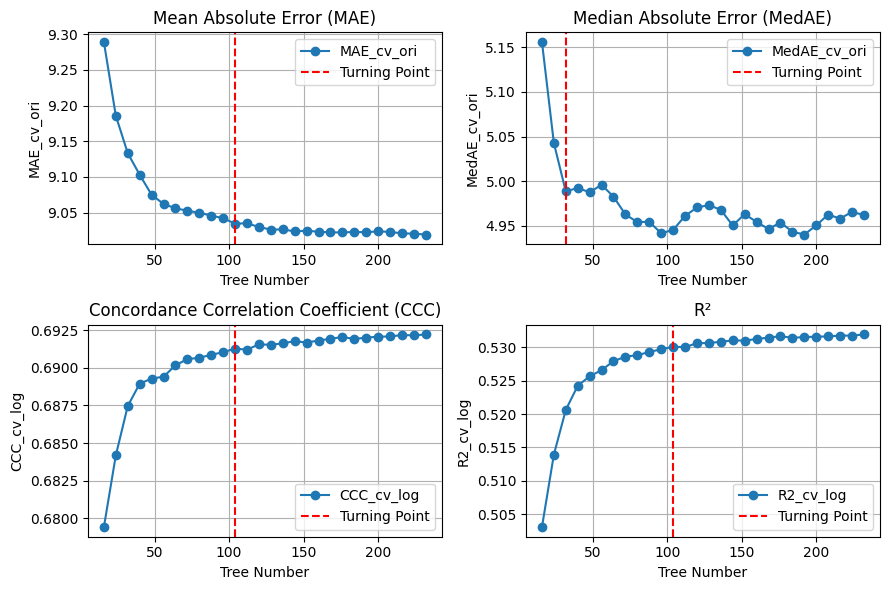

In [8]:
temp = rsl.groupby('tree number').mean().reset_index()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
temp['rank_MAE_cv_ori'] = temp['MAE_cv_ori'].rank(ascending=True) # Rank MAE and MAPE (smaller is better)
temp['rank_MedAE_cv_ori'] = temp['MedAE_cv_ori'].rank(ascending=True) # Rank MAE and MAPE (smaller is better)
# temp['rank_MAPE_cv_ori'] = temp['MAPE_cv_ori'].rank(ascending=True) 
temp['rank_CCC_cv_log'] = temp['CCC_cv_log'].rank(ascending=False) # Rank CCC and R2 (higher is better)
temp['rank_R2_cv_log'] = temp['R2_cv_log'].rank(ascending=False)
temp['combined_rank'] = temp[['rank_MAE_cv_ori', 'rank_R2_cv_log', 'rank_CCC_cv_log']].sum(axis=1) # Combine rankings
temp = temp.drop(columns = ['random state'])

turning_points = {
    'MAE_cv_ori': temp['MAE_cv_ori'][temp['MAE_cv_ori'].diff() > 0].index.min()-1,
    'MedAE_cv_ori': temp['MedAE_cv_ori'][temp['MedAE_cv_ori'].diff() > 0].index.min()-1,
    'CCC_cv_log': temp['CCC_cv_log'][temp['CCC_cv_log'].diff() < 0].index.min()-1,
    'R2_cv_log': temp['R2_cv_log'][temp['R2_cv_log'].diff() < 0].index.min()-1,
}

# Plot metrics against tree_number
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
metrics = ['MAE_cv_ori', 'MedAE_cv_ori', 'CCC_cv_log', 'R2_cv_log']
titles = ['Mean Absolute Error (MAE)', 'Median Absolute Error (MedAE)', 'Concordance Correlation Coefficient (CCC)', 'R²']

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    ax.plot(temp['tree number'], temp[metric], marker='o', label=f'{metric}')
    turning_point = turning_points[metric]
    if not pd.isna(turning_point):
        ax.axvline(temp['tree number'][turning_point], color='red', linestyle='--', label='Turning Point')
    ax.set_xlabel('Tree Number')
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Analysis Summary

From the plot, we observe:

- **Breaking Points**:
  - For **MAE**, **R²** and **CCC** the monotonically increasing trend stops at **104 trees**.
  - For **MedAE**, the breaking point occurs at **32 trees**.
- **Performance Gains**:
  - While performance continues to improve beyond the breaking points, the gains are minimal.

### Conclusion

To balance computational efficiency and model performance across all four metrics, we recommend using 120 as the tree number for the model.



# Parameter fine-funing based on this chosen tree number

In [3]:
### parameter fine tuning
spatial_cv_column = 'tile_id'
ccc_scorer = make_scorer(weighted_ccc, greater_is_better=True)
fitting_score = ccc_scorer

## no weights version
# random forest
ttprint('----------------------rf------------------------')
param_rf = {
    'n_estimators': [120],
    "criterion": ['squared_error', 'absolute_error', 'poisson', 'friedman_mse'],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
tune_rf = HalvingGridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_rf,
    scoring=fitting_score,
    n_jobs=90, 
    cv=cv,
    verbose=1,
    random_state = 1992
)

tune_rf.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
# warnings.filterwarnings('ignore')

[14:40:06] ----------------------rf------------------------
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 20
max_resources_: 4985
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 540
n_resources: 20
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
----------
iter: 1
n_candidates: 180
n_resources: 60
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 60
n_resources: 180
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 3
n_candidates: 20
n_resources: 540
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 4
n_candidates: 7
n_resources: 1620
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 5
n_candidates: 3
n_resources: 4860
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(cv=GroupKFold(n_splits=5),
                    estimator=RandomForestRegressor(), n_jobs=90,
                    param_grid={'criterion': ['squared_error', 'absolute_error',
                                              'poisson', 'friedman_mse'],
                                'max_depth': [10, 20, 30],
                                'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
                                'min_samples_leaf': [1, 2, 4],
                                'min_samples_split': [2, 5, 10],
                                'n_estimators': [120]},
                    random_state=1992, scoring=make_scorer(weighted_ccc),
                    verbose=1)

In [8]:
import joblib
rf = tune_rf.best_estimator_
print("Selected parameter space:", tune_rf.best_params_)
joblib.dump(rf, f'{folder_path}/data/010_model_fine.tuned.joblib')

Selected parameter space: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


['/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/test_model_fine.tuned.joblib']

# Fit the production model

In [7]:
all = pd.read_parquet(f'{folder_path}/data/003_data_overlaid.organized.pq')
all[tgt] = np.log1p(all[prop])

rf.n_jobs=90
rf.fit(all[covs], all[tgt])

joblib.dump(rf, f'{folder_path}/data/ocd_model_production.joblib')

['/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/ocd_model_production.joblib']